In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload


In [3]:
import sys
sys.path.append("..")  # assumes your notebooks/ folder is sibling to src/


In [4]:
from pathlib import Path
import pandas as pd
import numpy as np

from src.models.evaluate import mape, rmse, plot_forecast, results_table

PROC = Path("../data/processed")
ts = pd.read_csv(PROC/"ae_timeseries_clean.csv", parse_dates=["Date"])

# Seasonal-naive forecast (same month last year)
ts["y_hat_naive12"] = ts["y"].shift(12)

# Hold out last 12 months for validation
H = 12
train_ts = ts.iloc[:-H].copy()
valid_ts = ts.iloc[-H:].copy()

valid_eval = valid_ts.dropna(subset=["y_hat_naive12"]).copy()

naive_mape = mape(valid_eval["y"], valid_eval["y_hat_naive12"])
naive_rmse = rmse(valid_eval["y"], valid_eval["y_hat_naive12"])
print(f"Seasonal-Naive — MAPE: {naive_mape:.2f}% | RMSE: {naive_rmse:,.0f}")


Seasonal-Naive — MAPE: 3.10% | RMSE: 86,447


In [8]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import numpy as np
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX

from src.models.evaluate import mape, rmse

PROC = Path("../data/processed")
ts = pd.read_csv(PROC/"ae_timeseries_clean.csv", parse_dates=["Date"])

# Hold out last 12 months for validation
H = 12
train_ts = ts.iloc[:-H].copy()
valid_ts = ts.iloc[-H:].copy()

y_train = train_ts["y"].astype(float)
y_valid = valid_ts["y"].astype(float)

# Seasonal-naive for reference (if you haven't already computed)
ts["y_hat_naive12"] = ts["y"].shift(12)
valid_eval = ts.iloc[-H:].dropna(subset=["y_hat_naive12"]).copy()
naive_mape = mape(valid_eval["y"], valid_eval["y_hat_naive12"])
naive_rmse = rmse(valid_eval["y"], valid_eval["y_hat_naive12"])
print(f"Seasonal-Naive — MAPE: {naive_mape:.2f}% | RMSE: {naive_rmse:,.0f}")

# === SARIMAX AIC search ===
m = 12  # monthly seasonality
p = d = q = P = D = Q = [0, 1, 2]
best_aic = np.inf
best_order = None
best_seasonal = None
best_model = None

for order in itertools.product(p, d, q):
    for seasonal in itertools.product(P, D, Q):
        seasonal_order = (seasonal[0], seasonal[1], seasonal[2], m)
        try:
            model = SARIMAX(
                y_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(disp=False)
            if model.aic < best_aic:
                best_aic = model.aic
                best_order = order
                best_seasonal = seasonal_order
                best_model = model
        except Exception:
            continue

print("Best SARIMAX by AIC:", best_order, best_seasonal, "AIC:", round(best_aic, 2))

# Forecast next H months (validation)
sarimax_fc = best_model.forecast(steps=H)
valid_ts = valid_ts.copy()
valid_ts["y_hat_sarimax"] = sarimax_fc.values

sarimax_mape = mape(valid_ts["y"], valid_ts["y_hat_sarimax"])
sarimax_rmse = rmse(valid_ts["y"], valid_ts["y_hat_sarimax"])
print(f"SARIMAX — MAPE: {sarimax_mape:.2f}% | RMSE: {sarimax_rmse:,.0f}")


Seasonal-Naive — MAPE: 3.10% | RMSE: 86,447
Best SARIMAX by AIC: (0, 2, 2) (1, 2, 2, 12) AIC: 3150.99
SARIMAX — MAPE: 1.77% | RMSE: 50,287


In [9]:
from prophet import Prophet
from holidays import UnitedKingdom

# Prepare data for Prophet: needs columns 'ds' (date) and 'y'
df_prophet = ts[["Date", "y"]].rename(columns={"Date": "ds"})

# Add UK public holidays
years = range(df_prophet["ds"].dt.year.min(), df_prophet["ds"].dt.year.max() + 2)
holidays = []
for y in years:
    for d, name in UnitedKingdom(years=[y]).items():
        holidays.append({"ds": pd.to_datetime(d), "holiday": name})
holidays_df = pd.DataFrame(holidays)

m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,  # monthly data
    daily_seasonality=False,
    holidays=holidays_df,
    seasonality_mode="additive"
)

# Train on all but last 12 months
train_prophet = df_prophet.iloc[:-H]
valid_prophet = df_prophet.iloc[-H:]

m.fit(train_prophet)

# Forecast into validation window
future = m.make_future_dataframe(periods=H, freq="MS")  # 'MS' = month start
forecast = m.predict(future)

# Join with validation
valid_prophet = valid_prophet.copy()
valid_prophet["y_hat_prophet"] = forecast.set_index("ds").loc[valid_prophet["ds"], "yhat"].values

prophet_mape = mape(valid_prophet["y"], valid_prophet["y_hat_prophet"])
prophet_rmse = rmse(valid_prophet["y"], valid_prophet["y_hat_prophet"])

print(f"Prophet — MAPE: {prophet_mape:.2f}% | RMSE: {prophet_rmse:,.0f}")


17:51:52 - cmdstanpy - INFO - Chain [1] start processing
17:51:53 - cmdstanpy - INFO - Chain [1] done processing


Prophet — MAPE: 3.68% | RMSE: 95,537


In [14]:
import pandas as pd
from pathlib import Path

# Load engineered features
PROC = Path("../data/processed")
feat = pd.read_csv(PROC/"ae_features.csv", parse_dates=["Date"])

# Align to the same split as your ts (last 12 months = validation)
ts = pd.read_csv(PROC/"ae_timeseries_clean.csv", parse_dates=["Date"])
H = 12
cutoff_date = ts.iloc[-H]["Date"]

train_feat = feat[feat["Date"] < cutoff_date].copy()
valid_feat = feat[feat["Date"] >= cutoff_date].copy()

target = "y"
drop_cols = ["Date", target]

X_train = train_feat.drop(columns=drop_cols)
y_train = train_feat[target]

X_valid = valid_feat.drop(columns=drop_cols)
y_valid = valid_feat[target]

print("Train shape:", X_train.shape, "Valid shape:", X_valid.shape)



Train shape: (156, 18) Valid shape: (12, 18)


In [15]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

params = {
    "n_estimators": [200, 400, 600],
    "max_depth": [3, 4, 5],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
}

xgb = XGBRegressor(objective="reg:squarederror", random_state=42)
grid = GridSearchCV(
    xgb,
    params,
    scoring="neg_mean_absolute_percentage_error",
    cv=3,
    verbose=1
)

grid.fit(X_train, y_train)

best_xgb = grid.best_estimator_
yhat_tuned = best_xgb.predict(X_valid)

xgb_tuned_mape = mape(y_valid, yhat_tuned)
xgb_tuned_rmse = rmse(y_valid, yhat_tuned)

print("Best XGB params:", grid.best_params_)
print(f"Tuned XGB — MAPE: {xgb_tuned_mape:.2f}% | RMSE: {xgb_tuned_rmse:,.0f}")


Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best XGB params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 600, 'subsample': 1.0}
Tuned XGB — MAPE: 2.25% | RMSE: 57,489


In [16]:
from pathlib import Path
import pandas as pd

PROC = Path("../data/processed")
OUT = PROC / "predictions"
OUT.mkdir(parents=True, exist_ok=True)

# Ensure we have these in memory from earlier cells:
# ts (full timeline), valid_ts with 'y_hat_sarimax', valid_eval with 'y_hat_naive12'
# valid_prophet with 'ds' + 'y_hat_prophet', valid_feat with 'Date' + 'y_hat_xgb', y_valid

# Save each model's validation window predictions
valid_ts[["Date","y","y_hat_sarimax"]].to_csv(OUT/"valid_sarimax.csv", index=False)
valid_eval[["Date","y","y_hat_naive12"]].to_csv(OUT/"valid_naive12.csv", index=False)

tmp_prophet = valid_prophet.rename(columns={"ds":"Date"})[["Date","y","y_hat_prophet"]]
tmp_prophet.to_csv(OUT/"valid_prophet.csv", index=False)

tmp_xgb = valid_feat[["Date"]].copy()
tmp_xgb["y"] = y_valid.values
tmp_xgb["y_hat_xgb"] = yhat_tuned
tmp_xgb.to_csv(OUT/"valid_xgb.csv", index=False)
print("Saved predictions to", OUT.as_posix())


Saved predictions to ../data/processed/predictions


In [17]:
import numpy as np
from src.models.evaluate import mape, rmse

# Compute metrics consistently on the same validation months
val_dates = valid_ts["Date"]  # the last 12 months

# Align all predictions to these dates
df_join = pd.DataFrame({"Date": val_dates, "y": valid_ts["y"].values})

df_join = df_join.merge(valid_eval[["Date","y_hat_naive12"]], on="Date", how="left")
df_join = df_join.merge(valid_ts[["Date","y_hat_sarimax"]], on="Date", how="left")
df_join = df_join.merge(tmp_prophet[["Date","y_hat_prophet"]], on="Date", how="left")
df_join = df_join.merge(tmp_xgb[["Date","y_hat_xgb"]], on="Date", how="left")

scores = {
    "Seasonal-Naive": {
        "MAPE": mape(df_join["y"], df_join["y_hat_naive12"]),
        "RMSE": rmse(df_join["y"], df_join["y_hat_naive12"])
    },
    "SARIMAX": {
        "MAPE": mape(df_join["y"], df_join["y_hat_sarimax"]),
        "RMSE": rmse(df_join["y"], df_join["y_hat_sarimax"])
    },
    "Prophet": {
        "MAPE": mape(df_join["y"], df_join["y_hat_prophet"]),
        "RMSE": rmse(df_join["y"], df_join["y_hat_prophet"])
    },
    "XGB (tuned)": {
        "MAPE": mape(df_join["y"], df_join["y_hat_xgb"]),
        "RMSE": rmse(df_join["y"], df_join["y_hat_xgb"])
    }
}

leaderboard = (
    pd.DataFrame(scores).T
    .reset_index()
    .rename(columns={"index":"Model"})
    .sort_values("MAPE")
)

leaderboard.to_csv(OUT/"leaderboard.csv", index=False)
leaderboard


,Model,MAPE,RMSE
1,SARIMAX,1.765633,50286.708223
3,XGB (tuned),2.254089,57489.102117
0,Seasonal-Naive,3.096547,86446.714482
2,Prophet,3.677797,95536.854812


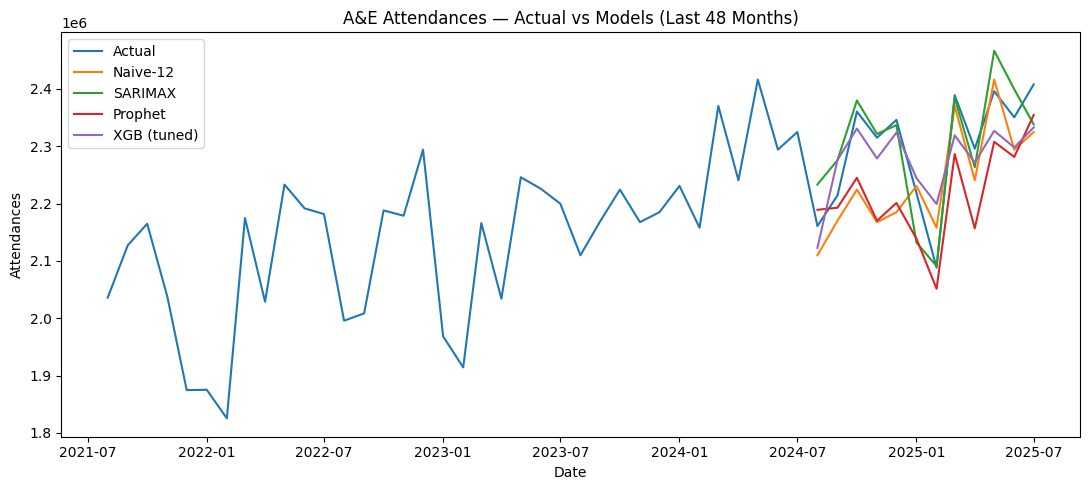

In [18]:
import matplotlib.pyplot as plt

# Merge predictions back onto the full timeline (for nicer plots)
plot_df = ts.copy()
plot_df = plot_df.merge(df_join[["Date","y_hat_naive12","y_hat_sarimax","y_hat_prophet","y_hat_xgb"]],
                        on="Date", how="left")

last_n = 48
tail = plot_df.iloc[-last_n:].copy()

plt.figure(figsize=(11,5))
plt.plot(tail["Date"], tail["y"], label="Actual")
plt.plot(tail["Date"], tail["y_hat_naive12"], label="Naive-12")
plt.plot(tail["Date"], tail["y_hat_sarimax"], label="SARIMAX")
plt.plot(tail["Date"], tail["y_hat_prophet"], label="Prophet")
plt.plot(tail["Date"], tail["y_hat_xgb"], label="XGB (tuned)")
plt.title("A&E Attendances — Actual vs Models (Last 48 Months)")
plt.xlabel("Date"); plt.ylabel("Attendances"); plt.legend()
plt.tight_layout(); plt.show()
